In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

深层神经网络的问题：
* 首先，梯度消失/爆炸问题
* 庞大网络，训练慢
* 参数越多，越容易过拟合

## Vanishing/Exploding Gradients Problem  梯度消失与梯度爆炸问题

我们可以通过反向传播算法来从输出层反向作用到输入层，传播梯度误差。

不幸的是，梯度经常会随着算法进展到更低层次时变得越来越小。导致的结果是，梯度下降在更低层网络连接权值更新方面基本没有改变，而且训练不会收敛到好的结果，这就是梯度消失问题。

在一些例子中会发生相反的现象，梯度会越来越大，导致很多层的权值疯狂增大，使得算法发散，这就是梯度爆炸，经常出现在循环神经网络中。

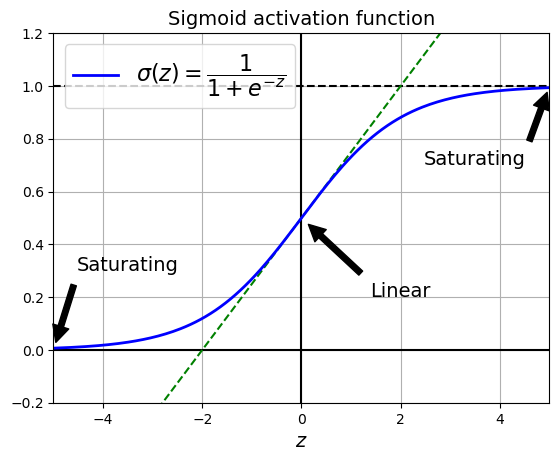

In [34]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.title("Sigmoid activation function", fontsize=14)
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

# save_fig("sigmoid_saturation_plot")
plt.show()

### Xavier初始化和He初始化

* Logistic uniform: $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Logistic normal: $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent uniform: $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent normal: $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) uniform: $ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) normal: $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $

In [9]:
# Keras中的初始化方法
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [10]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

- `he_normal`: He正态初始化

In [11]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

- 创建了一个VarianceScaling初始化器对象。VarianceScaling是一种权重初始化策略，它根据输入和/或输出神经元的数量来缩放权重。在这里，scale=2.表示每个神经元的权重的方差为2，mode='fan_avg'表示使用输入和输出神经元数量的平均值来计算缩放因子，distribution='uniform'表示使用均匀分布来随机生成权重。

### Nonsaturating Activation Functions  非饱和激活函数

Clorot和Bengio在2010年的论文中提出一个观点，梯度消失/爆炸问题一部分的原因是选错了激活函数。人类根据仿生，假定Sigmoid函数是一个绝佳的选择，然后现在看来，其他很多激活函数表现更好，尤其是relu函数，出现这种结果的原因最主要是因为它并不稀释正值(同时运算速度很快)

然而，Relu会出现dying Relu问题：在训练过程中，一些神经元实际上已经死了，即它们只会输出0.

其改进为leaky Relu，给负值添加一个很小的坡度，这会使该节点进入昏迷期，但最后还是有机会醒过来，有论文表明，leaky Relu总是优于Relu。

然后是PRelu，将负值坡度作为训练参数。

最后2015年有人提出新的激活函数ELU，在测试中，这总是优于前面所有的Relu的变种：训练时间减小，测试集表现更好。ELU和其他变种很像，只是有几个明显的不同。
* 第一，负值输出接近0，缓和梯度消失，超参数为当z很大时，ELU函数接近的值，一般为1.
* 第二，对于z<0有非0的梯度，避免节点死亡
* 整体平滑，提高梯度下降

ELU激活函数的缺陷是计算速度慢，但是在训练过程中收敛速度快。

2017年，又有人提出了SELU函数，在训练过程中，利用selu激活函数和lecun初始化，由一堆密集层组成的神经网络会自我规范化：在训练过程中，每一层的输出往往保持相同的均值和方差，从而解决了梯度消失/爆炸问题。因此，对于这样的神经网络，这个激活函数比其他的激活函数表现得非常好，所以你应该尝试一下。不幸的是，selu激活函数的自规范化特性很容易被破坏：不能使用1或2正则化、正则辍学、最大范数、跳跃连接或其他非顺序拓扑（因此递归神经网络不会自规范化）。然而，在实践中，它与连续cnn非常好地配合使用。如果你打破了自我规范化，selu不一定会优于其他激活函数。

默认的SELU有`scale`和`alpha`两个超参数,elu超参数（scale和alpha）的调整方式是，每个神经元的平均输出保持接近0，标准偏差保持接近1（假设输入也用平均值0和标准偏差1标准化）。使用此激活函数，即使是1000层深的神经网络，也会在所有层上保留大致的平均值0和标准差1，从而避免爆炸/消失梯度问题：

#### Leaky ReLU

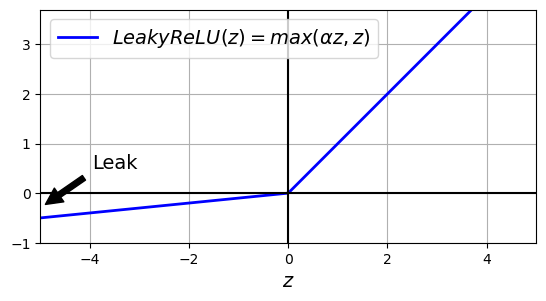

In [13]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 200)
# plt.figure(figsize=(7, 4))
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

# save_fig("leaky_relu_plot")
plt.show()

In [18]:
# 可用的激活函数
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [19]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [22]:
# 以Leaky ReLU为激活函数搭建网络模型
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [23]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [6]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.3065 - accuracy: 0.5952 - val_loss: 0.8725 - val_accuracy: 0.7144
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7856 - accuracy: 0.7387 - val_loss: 0.7018 - val_accuracy: 0.7706
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6745 - accuracy: 0.7762 - val_loss: 0.6360 - val_accuracy: 0.7912
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6156 - accuracy: 0.7949 - val_loss: 0.5823 - val_accuracy: 0.8068
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5774 - accuracy: 0.8062 - val_loss: 0.5516 - val_accuracy: 0.8176
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5505 - accuracy: 0.8141 - val_loss: 0.5297 - val_accuracy: 0.8268
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5302 - accuracy: 0.8197 - val_loss: 0.5118 - val_accuracy:

Now let's try PReLU:

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.4012 - accuracy: 0.5950 - val_loss: 0.9307 - val_accuracy: 0.7120
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8233 - accuracy: 0.7435 - val_loss: 0.7249 - val_accuracy: 0.7704
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6911 - accuracy: 0.7783 - val_loss: 0.6494 - val_accuracy: 0.7934
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6256 - accuracy: 0.7975 - val_loss: 0.5884 - val_accuracy: 0.8096
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5841 - accuracy: 0.8095 - val_loss: 0.5549 - val_accuracy: 0.8190
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5547 - accuracy: 0.8175 - val_loss: 0.5304 - val_accuracy: 0.8268
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5322 - accuracy: 0.8235 - val_loss: 0.5100 - val_accuracy:

其他训练方法

#### ELU

In [11]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

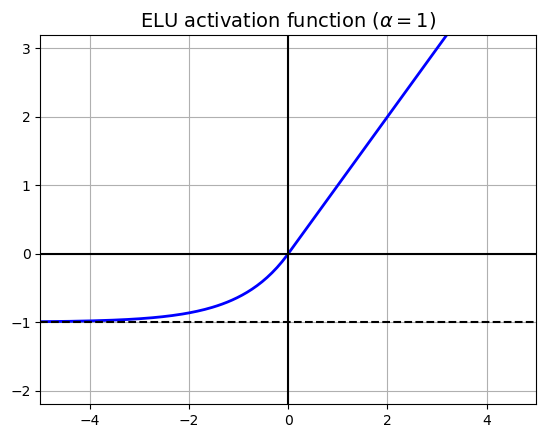

In [14]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()

在 TensorFlow 中实施 ELU 非常简单，只需在构建每一层时指定激活函数即可：

In [18]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

#### SELU

默认情况下，SELU 超参数（scale 和 alpha）的调整方式是使每个神经元的平均输出接近 0，标准偏差接近 1（假设输入也是标准化的，平均值为 0，标准偏差为 1，并遵守书中解释的其他约束条件）。使用这种激活函数，即使是 1,000 层的深度神经网络，也能在所有层中大致保持均值为 0、标准偏差为 1，从而避免爆炸/梯度消失问题：

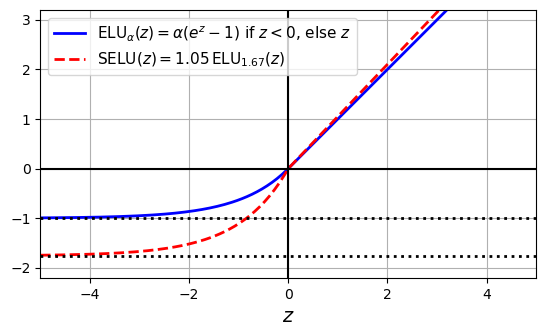

In [23]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend(loc='upper left', fontsize=11)

# save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [24]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**额外材料--使用 SELU 的自规则化网络示例:**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [25]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
# 创建100层使用SELU激活函数的隐层
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

不要忘记将输入比例调整为均值 0 和标准差 1：

In [27]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [28]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 19ms/step - loss: 1.1108 - accuracy: 0.5642 - val_loss: 0.7866 - val_accuracy: 0.7182
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.7584 - accuracy: 0.7201 - val_loss: 0.7289 - val_accuracy: 0.7408
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.8882 - accuracy: 0.6731 - val_loss: 0.8861 - val_accuracy: 0.6722
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.6762 - accuracy: 0.7514 - val_loss: 0.6225 - val_accuracy: 0.7720
Epoch 5/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.5690 - accuracy: 0.7913 - val_loss: 0.6002 - val_accuracy: 0.7720


尽管网络有多深，它还是成功地进行了学习。现在看看如果我们尝试使用 ReLU 激活函数会发生什么：

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 37s 20ms/step - loss: 1.9321 - accuracy: 0.2533 - val_loss: 1.5566 - val_accuracy: 0.3612
Epoch 2/5
1719/1719 [==============================] - 35s 20ms/step - loss: 1.3477 - accuracy: 0.4354 - val_loss: 1.2384 - val_accuracy: 0.4848
Epoch 3/5
1719/1719 [==============================] - 34s 20ms/step - loss: 1.2159 - accuracy: 0.4771 - val_loss: 1.1252 - val_accuracy: 0.4732
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.9611 - accuracy: 0.6237 - val_loss: 0.9564 - val_accuracy: 0.6264
Epoch 5/5
1719/1719 [==============================] - 32s 18ms/step - loss: 0.8642 - accuracy: 0.6717 - val_loss: 0.7781 - val_accuracy: 0.7172


- 遇到了梯度消失/爆炸的问题！！！

#### GELU, Swish and Mish

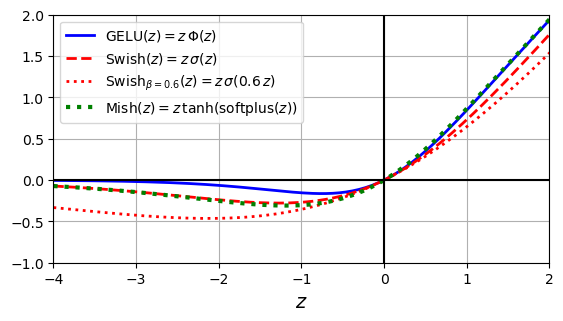

In [37]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 4, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=10)

# save_fig("gelu_swish_mish_plot")
plt.show()

### Batch Normalization  批量归一化